In [1]:
import TNG_DA
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
from pathlib import Path

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["TeX Gyre Pagella", "Book Antiqua", "Palatino Linotype", "DejaVu Serif"]
})

### Import BAHAMAS ROCKSTAR output

In [2]:
models = ["CDMb", "SIDM0.1b", "SIDM0.3b", "SIDM1b", "vdSIDMb", "tng"]
cluster_ids = [f"{i:03d}" for i in range(1, 101)]  # "001"..."100"
cluster_ids_tng = [f"{i:01d}" for i in range(0, 101)]  # "1"..."100"

column_names = ["id", "pos_0", "pos_1", "pos_2", "pos_3", "pos_4", "pos_5",
                "mass_grav", "vrms", "vmax", "rvmax", "p_start", "num_p"]

base_path = "/projects/mccleary_group/habjan.e/TNG/Data/rockstar_output"


subhalos_df_by_model = {}     # DataFrame of subhalos
members_df_by_model  = {}     # DataFrame of subhalo members

for model in models:
    subhalo_frames = []
    member_frames  = []
    npz_store = {}

    if model == 'tng':
        cluster_ids = cluster_ids_tng

    for cid in cluster_ids:

        if model == 'tng':
            subhalos_file = base_path + '/' + model + f"_rockstar_output/rockstar_subhalos_{cid}.list"
        else: 
            subhalos_file = base_path + '/' + model + f"_rockstar_output/bahamas_rockstar_subhalos_{model}_{cid}.list"

        df = pd.read_csv(subhalos_file, sep=r"\s+", comment="#", names=column_names, engine="python")
        df["cluster_id"] = cid
        df["dm_model"] = model
        subhalo_frames.append(df)

    subhalos_df_by_model[model] = pd.concat(subhalo_frames, ignore_index=True)

df_CDMb      = subhalos_df_by_model["CDMb"]
df_SIDM01b   = subhalos_df_by_model["SIDM0.1b"]
df_SIDM03b   = subhalos_df_by_model["SIDM0.3b"]
df_SIDM1b    = subhalos_df_by_model["SIDM1b"]
df_vdSIDMb   = subhalos_df_by_model["vdSIDMb"]
df_tng   = subhalos_df_by_model["tng"]

### 6-panel plot of rockstar bubbles

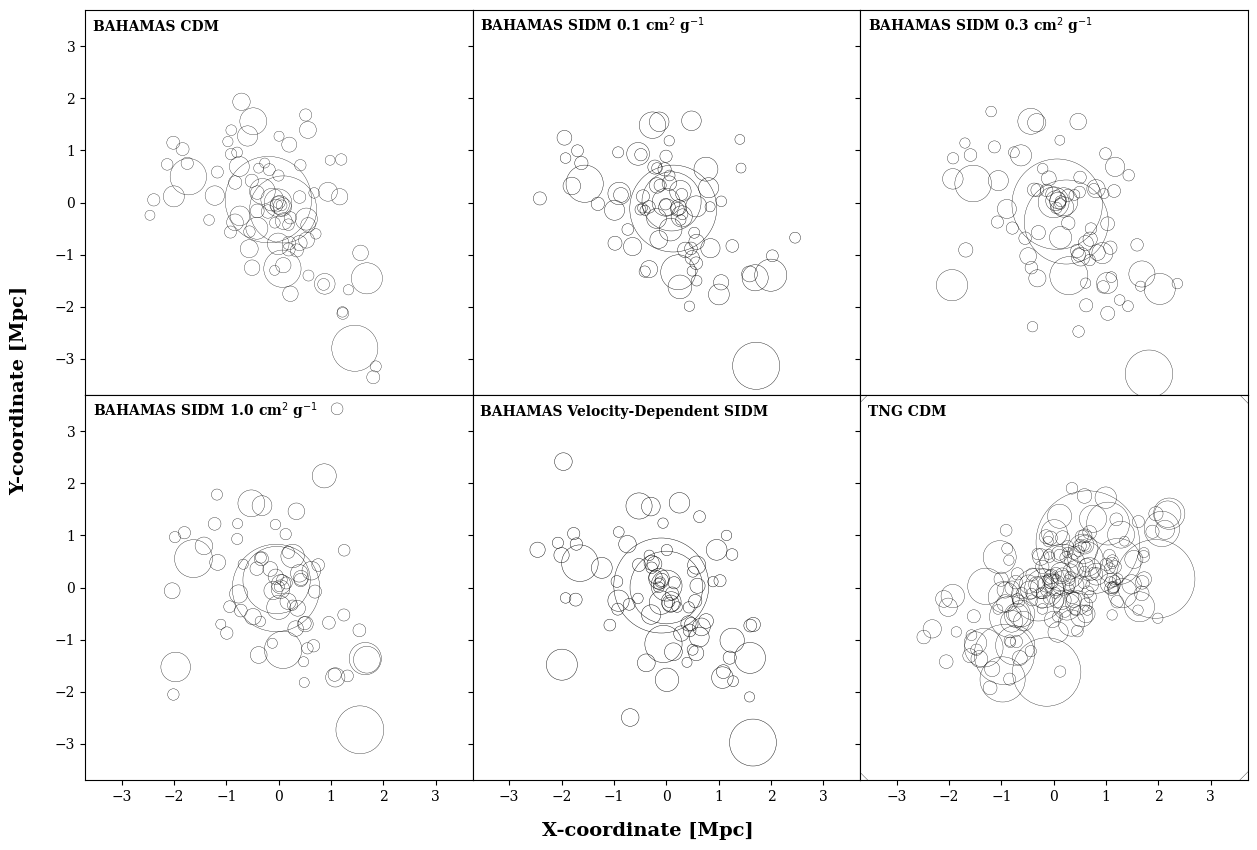

In [3]:
lim = 3.7

X_LIMITS = (-lim, lim)
Y_LIMITS = (-lim, lim)


# Example data
x = np.linspace(0, 10, 400)
ys = [np.sin(x + p) for p in np.linspace(0, np.pi, 6)]

# Create a 2x3 grid with shared axes and no spacing
fig, axes = plt.subplots(
    2, 3, figsize=(15, 10),
    sharex=True, sharey=True,
    gridspec_kw={"wspace": 0, "hspace": 0},
    constrained_layout=False
)

axes = axes.ravel()

z_low, z_up = -2, 2
sims = np.array(["CDMb", "SIDM0.1b", "SIDM0.3b", "SIDM1b", "vdSIDMb", "tng"])
sims_dict = {"CDMb":r"BAHAMAS CDM", "SIDM0.1b":r"BAHAMAS SIDM 0.1 cm$^2$ g$^{-1}$", "SIDM0.3b":r"BAHAMAS SIDM 0.3 cm$^2$ g$^{-1}$", 
             "SIDM1b":r"BAHAMAS SIDM 1.0 cm$^2$ g$^{-1}$", "vdSIDMb":"BAHAMAS Velocity-Dependent SIDM", "tng":"TNG CDM"}

# Plot
for i, ax in enumerate(axes):

    df = subhalos_df_by_model[sims[i]]

    ### Pick a cluster ID

    if sims[i] == 'tng':
        cl_id = '2'
        df = df[df['cluster_id'] == cl_id]
    else: 
        cl_id = '014'
        df = df[df['cluster_id'] == cl_id]

    sub_x_pos = np.array(df.loc[:, 'pos_0'])
    sub_y_pos = np.array(df.loc[:, 'pos_1'])
    num_p = np.array(df.loc[:, 'num_p'])

    if sims[i] == 'tng':
        num_p = num_p / 93

    sub_mask = np.where((df['pos_2'] > z_low) & (df['pos_2'] < z_up))[0]

    for j in sub_mask:

        ax.scatter(sub_x_pos[j], sub_y_pos[j], s=num_p[j], facecolors='none', edgecolors='k', linewidths=np.log10(num_p[i]) / 7.5, marker = 'o')
        ax.set_xlim(*X_LIMITS)
        ax.set_ylim(*Y_LIMITS)
    
    ax.text(-3.55, 3.30, sims_dict[sims[i]], fontsize=10, fontweight='semibold')

# Draw a single shared x/y label (optional)
fig.supxlabel("X-coordinate [Mpc]", fontsize=14, fontweight='semibold', y=0.05)
fig.supylabel("Y-coordinate [Mpc]", fontsize=14, fontweight='semibold', x=0.075)

#fig.savefig("/home/habjan.e/TNG/TNG_cluster_dynamics/figures/rockstar_bubbles.png", bbox_inches="tight")
plt.show()

### function for making plots

In [4]:
def binned_mass_function(x, bins, mode="per_host", n_hosts=1, use_log=True):
    """
    x: values to bin (e.g., log10 M if use_log=True, else M)
    bins: shared bin edges for all datasets (in same units as x)
    mode: "pdf", "per_host", or "cumulative"
    n_hosts: number of host halos represented by this sample (>=1)
    use_log: if True, interprets x & bins as log10; densities are per dex

    Returns: x_center, x_err, y, yerr_lo, yerr_hi
    """
    x = np.asarray(x)
    counts, _ = np.histogram(x, bins=bins)
    widths = np.diff(bins)
    centers = 0.5 * (bins[:-1] + bins[1:])
    xerr = 0.5 * widths

    # Gehrels (1986) approx for 68% CL Poisson errors (asymmetric)
    n = counts.astype(float)
    err_lo_counts = n - np.where(n>0, (np.sqrt(n + 0.75) - 1.0)**2, 0.0)
    err_hi_counts = (np.sqrt(n + 0.75) + 1.0)**2 - n

    if mode == "pdf":
        scale = n.sum()
        y = counts / (scale * widths) if scale > 0 else counts*0.0
        ylo = err_lo_counts / (scale * widths) if scale > 0 else counts*0.0
        yhi = err_hi_counts / (scale * widths) if scale > 0 else counts*0.0
    elif mode == "per_host":
        # differential mass function per host per dex (or per linear unit if use_log=False)
        denom = max(n_hosts, 1)
        y   = counts / (denom * widths)
        ylo = err_lo_counts / (denom * widths)
        yhi = err_hi_counts / (denom * widths)
    elif mode == "cumulative":
        # N(>x) per host; place at left edges’ centers for plotting
        c = counts[::-1].cumsum()[::-1]
        y   = c / max(n_hosts, 1)
        # simple symmetric sqrt(N) (or carry Gehrels cumulatives if desired)
        ylo = np.sqrt(c) / max(n_hosts, 1)
        yhi = ylo
        # for cumulative, xerr isn’t very meaningful:
        xerr = np.zeros_like(centers)
    else:
        raise ValueError("mode must be 'pdf', 'per_host', or 'cumulative'")

    # return arrays with only bins that had any data or keep all (here we keep all)
    return centers, xerr, y, ylo, yhi

### Make data arrays

In [5]:
vmax_CDMb = np.array(df_CDMb['vmax'])
vmax_SIDM01b  = np.array(df_SIDM01b ['vmax'])
vmax_SIDM03b  = np.array(df_SIDM03b['vmax'])
vmax_SIDM1b  = np.array(df_SIDM1b ['vmax'])
vmax_vdSIDMb = np.array(df_vdSIDMb['vmax'])
vmax_tng = np.array(df_tng['vmax'])

vrms_CDMb = np.array(df_CDMb['vrms'])
vrms_SIDM01b  = np.array(df_SIDM01b ['vrms'])
vrms_SIDM03b  = np.array(df_SIDM03b['vrms'])
vrms_SIDM1b  = np.array(df_SIDM1b ['vrms'])
vrms_vdSIDMb = np.array(df_vdSIDMb['vrms'])
vrms_tng = np.array(df_tng['vrms'])

mass_CDMb = np.log10(np.array(df_CDMb['mass_grav']))
mass_SIDM01b  = np.log10(np.array(df_SIDM01b ['mass_grav']))
mass_SIDM03b  = np.log10(np.array(df_SIDM03b['mass_grav']))
mass_SIDM1b  = np.log10(np.array(df_SIDM1b ['mass_grav']))
mass_vdSIDMb = np.log10(np.array(df_vdSIDMb['mass_grav']))
mass_tng = np.log10(np.array(df_tng['mass_grav']))

/tmp/ipykernel_3403821/1532094234.py:15: RuntimeWarning: divide by zero encountered in log10
  mass_CDMb = np.log10(np.array(df_CDMb['mass_grav']))
/tmp/ipykernel_3403821/1532094234.py:16: RuntimeWarning: divide by zero encountered in log10
  mass_SIDM01b  = np.log10(np.array(df_SIDM01b ['mass_grav']))
/tmp/ipykernel_3403821/1532094234.py:17: RuntimeWarning: divide by zero encountered in log10
  mass_SIDM03b  = np.log10(np.array(df_SIDM03b['mass_grav']))
/tmp/ipykernel_3403821/1532094234.py:18: RuntimeWarning: divide by zero encountered in log10
  mass_SIDM1b  = np.log10(np.array(df_SIDM1b ['mass_grav']))
/tmp/ipykernel_3403821/1532094234.py:19: RuntimeWarning: divide by zero encountered in log10
  mass_vdSIDMb = np.log10(np.array(df_vdSIDMb['mass_grav']))


### Mass, Velocity Dispersion, and Max Circular Velocity distributions

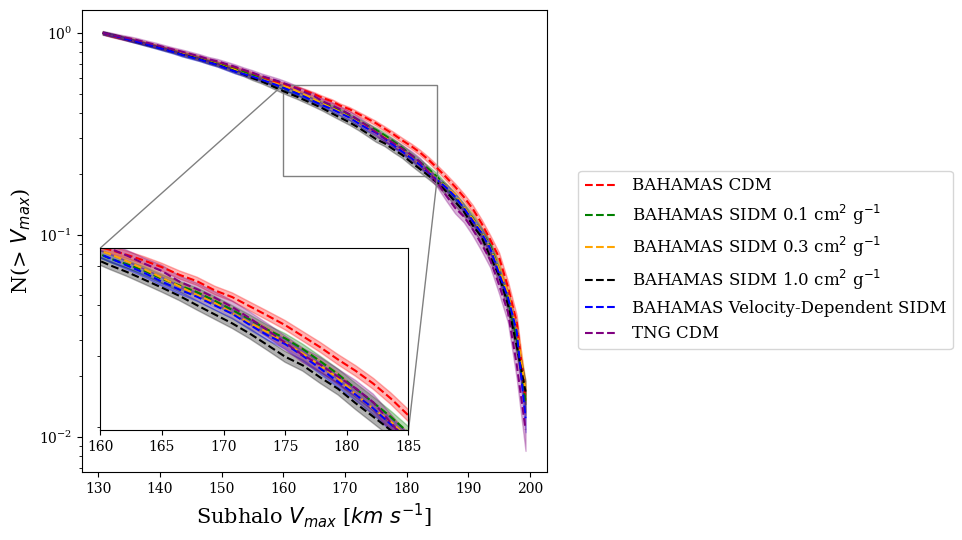

In [6]:
num_bins = 50
vmax_low, vmax_up = 130, 200
bins = np.linspace(vmax_low, vmax_up, num_bins)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6), sharey=False)
plt.subplots_adjust(wspace=0.225)

### Left plot: cumulative max circular velocity function

axins1 = zoomed_inset_axes(ax1, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax1.transAxes)
zoom_min, zoom_max = 160, 185
zoom_y_list = []

for data, color, label in [
    (vmax_CDMb[(vmax_CDMb > vmax_low) & (vmax_CDMb < vmax_up)],   'red',   r"BAHAMAS CDM"),
    (vmax_SIDM01b[(vmax_SIDM01b > vmax_low) & (vmax_SIDM01b < vmax_up)],   'green',   r"BAHAMAS SIDM 0.1 cm$^2$ g$^{-1}$"),
    (vmax_SIDM03b[(vmax_SIDM03b > vmax_low) & (vmax_SIDM03b < vmax_up)],   'orange',   r"BAHAMAS SIDM 0.3 cm$^2$ g$^{-1}$"),
    (vmax_SIDM1b[(vmax_SIDM1b > vmax_low) & (vmax_SIDM1b < vmax_up)],   'black',   r"BAHAMAS SIDM 1.0 cm$^2$ g$^{-1}$"),
    (vmax_vdSIDMb[(vmax_vdSIDMb > vmax_low) & (vmax_vdSIDMb < vmax_up)],'blue',  "BAHAMAS Velocity-Dependent SIDM"),
    (vmax_tng[(vmax_tng > vmax_low) & (vmax_tng < vmax_up)], 'purple',  'TNG CDM'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    ax1.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins1.plot(x_mean, y, c=color, linestyle='--')
    axins1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins1.set_xlim(zoom_min, zoom_max)
axins1.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins1.tick_params(axis='y', which='both', labelleft=False)
axins1.set_yscale('log')
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

ax1.set_yscale('log')

ax1.set_ylabel('N(> $V_{max}$)', fontsize = 15)
ax1.set_xlabel(r'Subhalo $V_{max}$ [$km$ $s^{-1}$]', fontsize = 15)

ax1.legend(bbox_to_anchor=(1.05, 0.67), fontsize = 12)

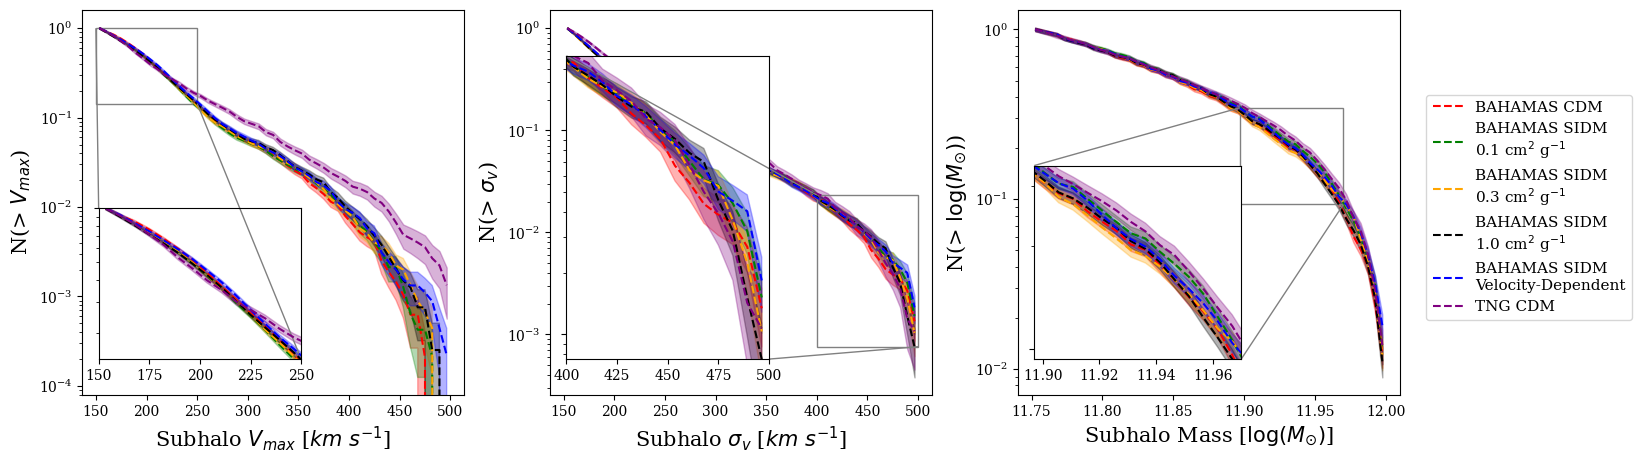

In [12]:
num_bins = 50
vmax_low, vmax_up = 150, 500
bins = np.linspace(vmax_low, vmax_up, num_bins)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5), sharey=False)
plt.subplots_adjust(wspace=0.225)

### Left plot: cumulative max circular velocity function

axins1 = zoomed_inset_axes(ax1, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax1.transAxes)
zoom_min, zoom_max = 150, 250
zoom_y_list = []

for data, color, label in [
    (vmax_CDMb[(vmax_CDMb > vmax_low) & (vmax_CDMb < vmax_up)],   'red',   r"BAHAMAS CDM"),
    (vmax_SIDM01b[(vmax_SIDM01b > vmax_low) & (vmax_SIDM01b < vmax_up)],   'green',   r"BAHAMAS SIDM 0.1 cm$^2$ g$^{-1}$"),
    (vmax_SIDM03b[(vmax_SIDM03b > vmax_low) & (vmax_SIDM03b < vmax_up)],   'orange',   r"BAHAMAS SIDM 0.3 cm$^2$ g$^{-1}$"),
    (vmax_SIDM1b[(vmax_SIDM1b > vmax_low) & (vmax_SIDM1b < vmax_up)],   'black',   r"BAHAMAS SIDM 1.0 cm$^2$ g$^{-1}$"),
    (vmax_vdSIDMb[(vmax_vdSIDMb > vmax_low) & (vmax_vdSIDMb < vmax_up)],'blue',  "BAHAMAS Velocity-Dependent SIDM"),
    (vmax_tng[(vmax_tng > vmax_low) & (vmax_tng < vmax_up)], 'purple',  'TNG CDM'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    # points with both horizontal (std in bin) and vertical (Poisson on density) errors
    #ax1.errorbar(x_mean, y, xerr=x_std, yerr=y_err,
     #            fmt='o', ms=3, capsize=2, elinewidth=1,
      #           color=color, label=label, linestyle='none', alpha=0.9)
    ax1.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins1.plot(x_mean, y, c=color, linestyle='--')
    axins1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins1.set_xlim(zoom_min, zoom_max)
axins1.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins1.tick_params(axis='y', which='both', labelleft=False)
axins1.set_yscale('log')
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

### Center plot: cumulative velocity dispersion function

vrms_low, vrms_up = 150, 500
bins = np.linspace(vrms_low, vrms_up, num_bins)

axins2 = zoomed_inset_axes(ax2, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax2.transAxes)
zoom_min, zoom_max = 400, 500
zoom_y_list = []

for data, color, label in [
    (vrms_CDMb[(vrms_CDMb > vrms_low) & (vrms_CDMb < vrms_up)],   'red',   r"BAHAMAS CDM"),
    (vrms_SIDM01b[(vrms_SIDM01b > vrms_low) & (vrms_SIDM01b < vrms_up)],   'green',   r"BAHAMAS SIDM 0.1 cm$^2$ g$^{-1}$"),
    (vrms_SIDM03b[(vrms_SIDM03b > vrms_low) & (vrms_SIDM03b < vrms_up)],   'orange',   r"BAHAMAS SIDM 0.3 cm$^2$ g$^{-1}$"),
    (vrms_SIDM1b[(vrms_SIDM1b > vrms_low) & (vrms_SIDM1b < vrms_up)],   'black',   r"BAHAMAS SIDM 1.0 cm$^2$ g$^{-1}$"),
    (vrms_vdSIDMb[(vrms_vdSIDMb > vrms_low) & (vrms_vdSIDMb < vrms_up)],'blue',  "BAHAMAS Velocity-Dependent SIDM"),
    (vrms_tng[(vrms_tng > vrms_low) & (vrms_tng < vrms_up)], 'purple',  'TNG CDM'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    # points with both horizontal (std in bin) and vertical (Poisson on density) errors
    #ax2.errorbar(x_mean, y, xerr=x_std, yerr=y_err,
     #            fmt='o', ms=3, capsize=2, elinewidth=1,
      #           color=color, label=label, linestyle='none', alpha=0.9)
    ax2.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax2.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins2.plot(x_mean, y, c=color, linestyle='--')
    axins2.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins2.set_xlim(zoom_min, zoom_max)
axins2.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins2.tick_params(axis='y', which='both', labelleft=False)
axins2.set_yscale('log')
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

### Right plot: cumulative mass function

mass_low, mass_up = 11.75, 12
bins = np.linspace(mass_low, mass_up, num_bins)

axins3 = zoomed_inset_axes(ax3, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax3.transAxes)
zoom_min, zoom_max = 11.897, 11.97
zoom_y_list = []

for data, color, label in [
    (mass_CDMb[(mass_CDMb > mass_low) & (mass_CDMb < mass_up)],   'red',   r"BAHAMAS CDM"),
    (mass_SIDM01b[(mass_SIDM01b > mass_low) & (mass_SIDM01b < mass_up)],   'green',   r"BAHAMAS SIDM" + '\n' + r"0.1 cm$^2$ g$^{-1}$"),
    (mass_SIDM03b[(mass_SIDM03b > mass_low) & (mass_SIDM03b < mass_up)],   'orange',   r"BAHAMAS SIDM" + '\n' + r"0.3 cm$^2$ g$^{-1}$"),
    (mass_SIDM1b[(mass_SIDM1b > mass_low) & (mass_SIDM1b < mass_up)],   'black',   r"BAHAMAS SIDM" + '\n' + r"1.0 cm$^2$ g$^{-1}$"),
    (mass_vdSIDMb[(mass_vdSIDMb > mass_low) & (mass_vdSIDMb < mass_up)],'blue',  "BAHAMAS SIDM" + '\n' + r"Velocity-Dependent"),
    (mass_tng[(mass_tng > mass_low) & (mass_tng < mass_up)], 'purple',  'TNG CDM'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    # points with both horizontal (std in bin) and vertical (Poisson on density) errors
    #ax3.errorbar(x_mean, y, xerr=x_std, yerr=y_err,
     #            fmt='o', ms=3, capsize=2, elinewidth=1,
      #           color=color, label=label, linestyle='none', alpha=0.9)
    
    ax3.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax3.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins3.plot(x_mean, y, c=color, linestyle='--')
    axins3.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins3.set_xlim(zoom_min, zoom_max)
axins3.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins3.tick_params(axis='y', which='both', labelleft=False)
axins3.set_yscale('log')
mark_inset(ax3, axins3, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax1.set_ylabel('N(> $V_{max}$)', fontsize = 15)
ax1.set_xlabel(r'Subhalo $V_{max}$ [$km$ $s^{-1}$]', fontsize = 15)

ax2.set_ylabel('N(> $\sigma_v$)', fontsize = 15)
ax2.set_xlabel(r'Subhalo $\sigma_v$ [$km$ $s^{-1}$]', fontsize = 15)

ax3.set_ylabel('N(> $\log(M_{\odot})$)', fontsize = 15)
ax3.set_xlabel(r'Subhalo Mass [$\log(M_{\odot})$]', fontsize = 15)

#ax1.legend(loc='lower left')
#ax2.legend(loc='lower left')
ax3.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11)

# DS+ and Virial Theorem plots

In [177]:
cluster_sub_prob = np.zeros(101)

for i in range(0, 101):

    df = pd.read_csv(dsp_results_path + f"DS+_Virial_df_{i}.csv")

    if np.isnan(np.array(df['Completeness'])).all():

        cluster_sub_prob[i] = 1

np.where(cluster_sub_prob == 1)[0].shape

(83,)

In [185]:
np.where(cluster_sub_prob == 0)[0]

array([ 3, 10, 14, 15, 18, 21, 23, 27, 33, 51, 66, 68, 71, 72, 83, 85, 92,
       99])

In [207]:
cluster = 99

pos, vel, groups, subhalo_masses, h, halo_mass = TNG_DA.get_cluster_props(cluster)

Cluster 99 has a $M_{200}$ less than 15.0 $\log(M_\odot)$

### Import Data

In [208]:
dsp_results_path = '/projects/mccleary_group/habjan.e/TNG/Data/data_DS+_virial_results/'

df = pd.read_csv(dsp_results_path + f"DS+_Virial_df_{cluster}.csv")
subhalo_masses = np.load(dsp_results_path + f"subhalo_masses_{cluster}.npy", allow_pickle=True)
velocity_dispersion = np.load(dsp_results_path + f"velocity_dispersion_{cluster}.npy", allow_pickle=True)
dsp_out_1 = np.load(dsp_results_path + f'DS+_array_1_{cluster}.npy')
dsp_out_2 = np.load(dsp_results_path + f'DS+_array_2_{cluster}.npy')
dsp_out_3 = np.load(dsp_results_path + f'DS+_array_3_{cluster}.npy', allow_pickle=True)

### Make array of projections

In [209]:
x_proj = np.array(df['Projection x-Direction'])
y_proj = np.array(df['Projection y-Direction'])
z_proj = np.array(df['Projection z-Direction'])

df_proj_arr = np.transpose(np.array([x_proj, y_proj, z_proj]))

virial_cluster_mass = np.array(df['Virial Halo Mass'])

### Run DS+ for a projection from the dataframe

In [210]:
pos_2d, vel_los = TNG_DA.project_3d_to_2d(pos, vel, viewing_direction=np.array([x_proj[0], y_proj[0], z_proj[0]]))

#test, C, P = TNG_DA.run_dsp(pos_2d, vel_los, groups, n_sims=500, Plim_P = 50, Ng_jump=1, cluster_name = None)
test, C, P = TNG_DA.run_dsp(pos_2d, vel_los, groups, n_sims=50, Plim_P = 50, Ng_jump=1, cluster_name = None)
C, P

/home/habjan.e/TNG/Codes/DS+/MilaDS/tools_DS.py:382: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  locsDF = pd.concat([locsDF, iterDF1])
/home/habjan.e/TNG/Codes/DS+/MilaDS/tools_DS.py:395: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evalDF = pd.concat([evalDF, iterDF2])


end DS+ individual probabilities
end DS+ groups location
end summary DS+ groups
8  DS+ groups detected


(0.5, 0.041666666666666664)

### Make a DS+ -- TNG plot

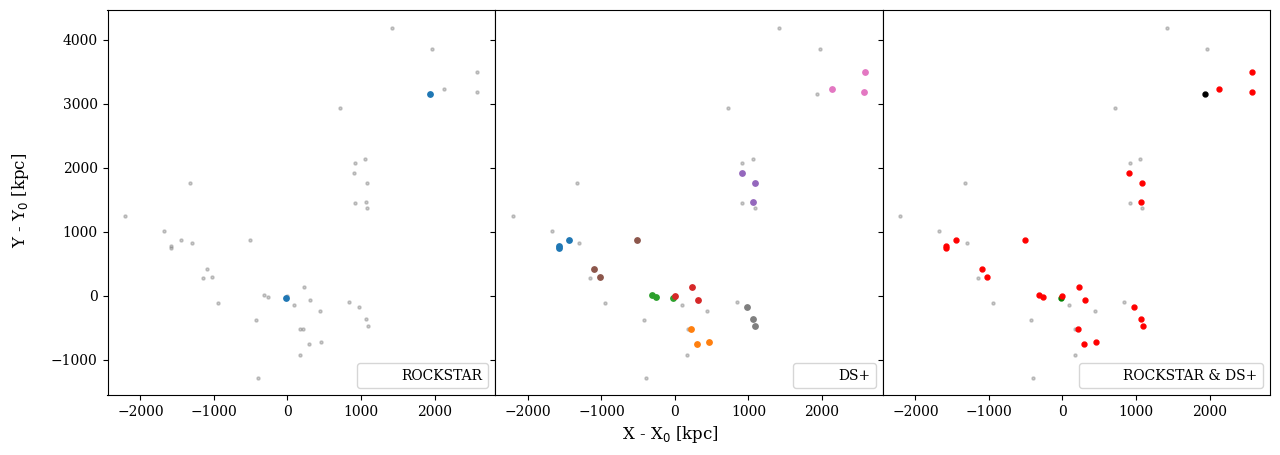

In [211]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

tng_arr = np.zeros(len(vel_los))
dsp_arr = np.zeros(len(vel_los))

### TNG subgroups

k = 0

for g in np.unique(groups):

    group_bool = groups == g

    if k == 0:

        ax1.scatter(0, 0, c='white', alpha=0, label='ROCKSTAR')
        k += 1

    if len(groups[group_bool]) > 1 and len(groups[group_bool]) < int(np.sqrt(len(vel_los))):
        
        
        ax1.scatter(pos_2d[group_bool, 0], pos_2d[group_bool, 1], s=15)
        tng_arr[group_bool] = 1
    
    else:

        ax1.scatter(pos_2d[group_bool, 0], pos_2d[group_bool, 1], s=5, c='gray', alpha =0.4)
        tng_arr[group_bool] = 2

ax1.legend(loc = 'lower right')

### DS+ subgroups

sub_grnu, sub_count = np.unique(test[1][:, 8], return_counts=True)
sub_grnu_arr = test[1][:, 8]

for i in range(len(sub_grnu)):

    if i == 0:

        ax2.scatter(0, 0, c='white', alpha=0, label='DS+')

    group_dsp_arr = np.where(sub_grnu_arr == sub_grnu[i])[0]
    x = test[1][group_dsp_arr, 9]
    y = test[1][group_dsp_arr, 10]

    if sub_count[i] > 1 and sub_count[i] < int(np.sqrt(len(vel_los))):

        ax2.scatter(x, y, s=15)
        dsp_arr[group_dsp_arr] = 1
    
    else:

        ax2.scatter(x, y, s=5, c='gray', alpha =0.4)
        dsp_arr[group_dsp_arr] = 2

ax2.legend(loc = 'lower right')

### Plot comparing TNG and DS+ substructure

ax3.scatter(0, 0, c='white', alpha=0, label='ROCKSTAR & DS+')

# DS+ correctly identifies a galaxy that is part of substructure
bool_corr = (tng_arr == 1) & (dsp_arr == 1)
ax3.scatter(pos_2d[bool_corr, 0], pos_2d[bool_corr, 1], c = 'green' , s=12.5)

# Galaxies that are not part of substructure and where not identified by DS +
bool_indiff = (tng_arr == 2) & (dsp_arr == 2)
ax3.scatter(pos_2d[bool_indiff, 0], pos_2d[bool_indiff, 1], s=5, c='gray', alpha =0.4)

# Galaxies that are part of substructure but were not identified by DS+
bool_noid = (tng_arr == 1) & (dsp_arr == 2)
ax3.scatter(pos_2d[bool_noid, 0], pos_2d[bool_noid, 1], c = 'black', s=12.5)

# Galaxies not part of substructure but were identified by DS+
bool_wrong = (tng_arr == 2) & (dsp_arr == 1)
ax3.scatter(pos_2d[bool_wrong, 0], pos_2d[bool_wrong, 1], c = 'red', s=12.5)

ax3.legend(loc = 'lower right')

### Adjust layout and show plot

#fig.suptitle(f'TNG Cluster Index: {cluster_TNG} | Orientation: {view_vector}')
fig.supxlabel(r'X - X$_0$ [kpc]')
fig.supylabel(r'Y - Y$_0$ [kpc]' , x=0.06)

fig.subplots_adjust(wspace=0)

plt.show()

### Quantifying Trixiality

In [130]:
tri_results = np.transpose(np.array([TNG_DA.compare_3d_2d_shape(pos, vel, df_proj_arr[i]) for i in range(len(df))]))

shape_3d = tri_results[0]
shape_2d = tri_results[1]
tri_metric_arr = tri_results[2]
T = tri_results[3, 0]

### Calculate differences in true 3D velocity dispersion and assumed los velocity dispersion

In [131]:
true_disp_x = np.sum((vel[:, 0] - np.mean(vel[:, 0]))**2) / len(vel[:, 0])
true_disp_y = np.sum((vel[:, 1] - np.mean(vel[:, 1]))**2) / len(vel[:, 1])
true_disp_z = np.sum((vel[:, 2] - np.mean(vel[:, 2]))**2) / len(vel[:, 2])
true_vel_disp = np.sqrt(true_disp_x + true_disp_y + true_disp_z)

los_velocities = np.array([TNG_DA.project_3d_to_2d(pos, vel, df_proj_arr[i])[1] for i in range(df_proj_arr.shape[0])])
vel_los_disp = np.array([np.sqrt((1 / (len(los_velocities[i]) - 1)) * np.sum((los_velocities[i] - np.mean(los_velocities[i]))**2)) for i in range(los_velocities.shape[0])]) * np.sqrt(3)

### Plot mass difference versus the triaxiality metric

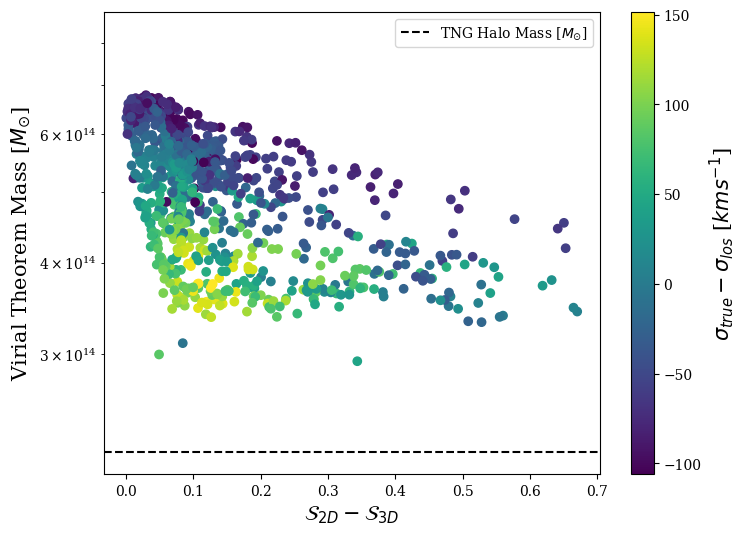

In [132]:
vel_disp_diff = true_vel_disp - vel_los_disp

plt.figure(figsize=(8, 6))

sc = plt.scatter(tri_metric_arr, virial_cluster_mass, c=vel_disp_diff, cmap='viridis')
plt.axhline(halo_mass, c='k', linestyle='--', label=r'TNG Halo Mass [$M_{\odot}$]')

cbar = plt.colorbar(sc)
cbar.set_label(r'$\sigma_{true} - \sigma_{los}$ [$km s^{-1}$]', fontsize = 15)

plt.ylim(np.min(virial_cluster_mass) * 0.7, np.max(virial_cluster_mass) * 1.3)

plt.xlabel(r'$ \mathcal{S}_{2D} - \mathcal{S}_{3D}$', fontsize = 15)
plt.ylabel(r'Virial Theorem Mass [$M_{\odot}$]', fontsize = 15)
plt.legend()
plt.yscale('log')

Text(0, 0.5, 'Virial Theorem Mass [$log_{10}(M_{\\odot})$]')

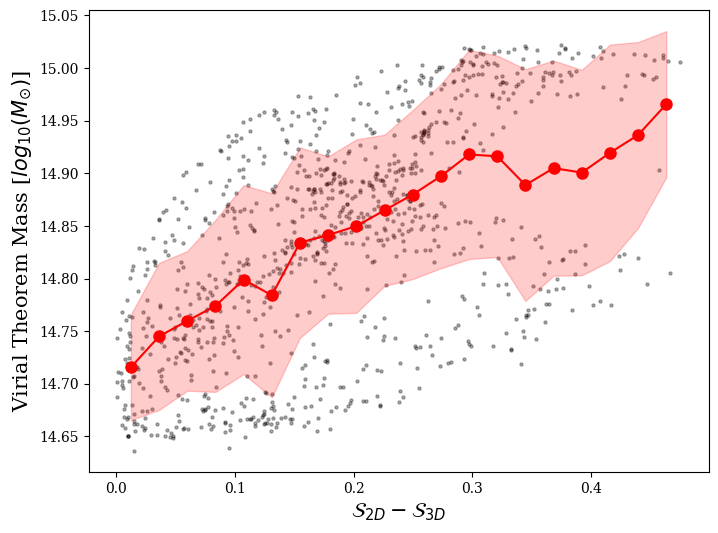

In [105]:
x = tri_metric_arr
y = np.log10(virial_cluster_mass)

num_bins = 20 
bins = np.linspace(min(x), max(x), num_bins + 1)
bin_indices = np.digitize(x, bins) - 1

# Compute statistics per bin (mean, median, etc.)
bin_means = np.array([np.mean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_std = np.array([np.std(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers

# Plot original data as scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=5, c ='k', alpha = 0.3)

# Plot binned means as points or line
plt.plot(bin_centers, bin_means, 'ro-', markersize=8)
plt.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='red', alpha=0.2)

plt.xlabel(r'$ \mathcal{S}_{2D} - \mathcal{S}_{3D}$', fontsize = 15)
plt.ylabel(r'Virial Theorem Mass [$log_{10}(M_{\odot})$]', fontsize = 15)

### Completeness

Text(0, 0.5, 'Completeness')

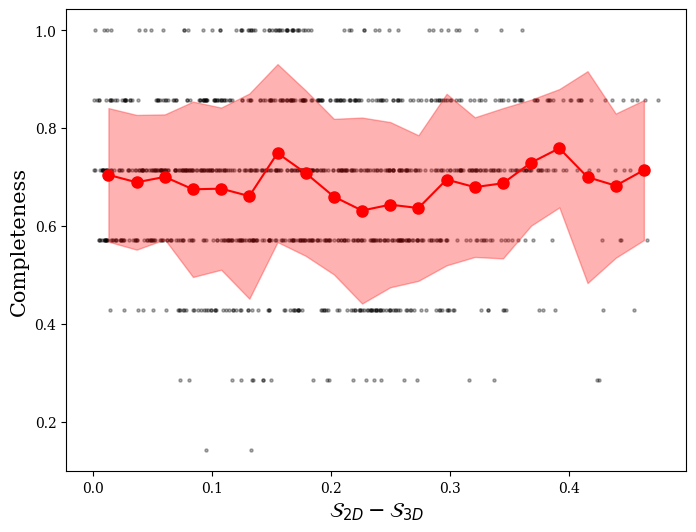

In [106]:
complete = np.array(df['Completeness'])
complete_err = np.array(df['Completeness Uncertainty'])

x = tri_metric_arr
y = complete

num_bins = 20 
bins = np.linspace(min(x), max(x), num_bins + 1)
bin_indices = np.digitize(x, bins) - 1

# Compute statistics per bin (mean, median, etc.)
bin_means = np.array([np.mean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_std = np.array([np.std(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers

# Plot original data as scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=5, c ='k', alpha = 0.3)

# Plot binned means as points or line
plt.plot(bin_centers, bin_means, 'ro-', markersize=8)
plt.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='red', alpha=0.3)

plt.xlabel(r'$ \mathcal{S}_{2D} - \mathcal{S}_{3D}$', fontsize = 15)
plt.ylabel('Completeness', fontsize = 15)

### Purity

Text(0, 0.5, 'Purity')

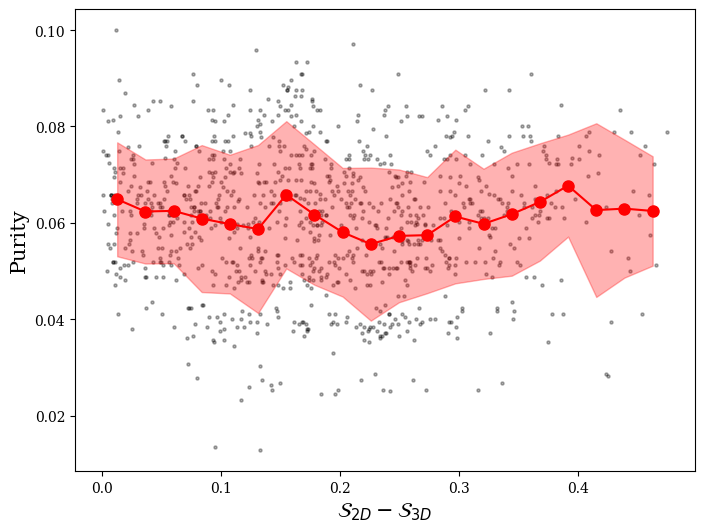

In [107]:
purity = np.array(df['Purity'])
purity_err = np.array(df['Purity Uncertainty'])

x = tri_metric_arr
y = purity

num_bins = 20 
bins = np.linspace(min(x), max(x), num_bins + 1)
bin_indices = np.digitize(x, bins) - 1

# Compute statistics per bin (mean, median, etc.)
bin_means = np.array([np.mean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_std = np.array([np.std(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers

# Plot original data as scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=5, c ='k', alpha = 0.3)

# Plot binned means as points or line
plt.plot(bin_centers, bin_means, 'ro-', markersize=8)
plt.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color='red', alpha=0.3)

plt.xlabel(r'$ \mathcal{S}_{2D} - \mathcal{S}_{3D}$', fontsize = 15)
plt.ylabel('Purity', fontsize = 15)

### Subhalo plot from DS+ 

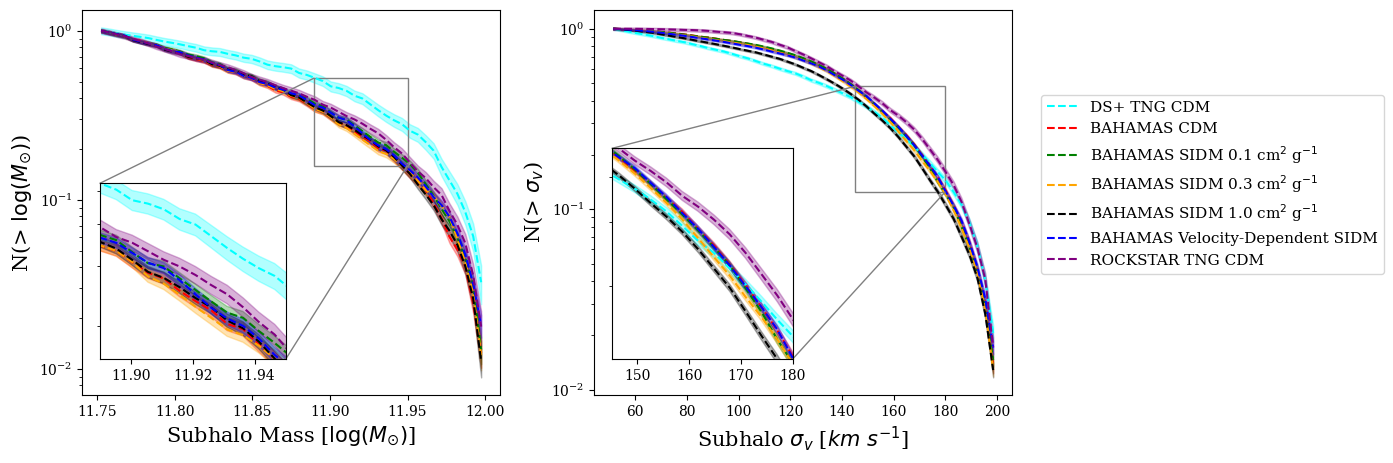

In [108]:
num_bins = 50
mass_low, mass_up = 11.75, 12
bins = np.linspace(mass_low, mass_up, num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
plt.subplots_adjust(wspace=0.225)

### Left plot: cumulative subhalo mass function

axins1 = zoomed_inset_axes(ax1, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax1.transAxes)
zoom_min, zoom_max = 11.89, 11.95
zoom_y_list = []

dsp_masses = np.log10(np.concatenate(subhalo_masses))

for data, color, label in [
    (dsp_masses[(dsp_masses > mass_low) & (dsp_masses < mass_up)],   'cyan',   r"DS+"),
    (mass_CDMb[(mass_CDMb > mass_low) & (mass_CDMb < mass_up)],   'red',   r"BAHAMAS CDM"),
    (mass_SIDM01b[(mass_SIDM01b > mass_low) & (mass_SIDM01b < mass_up)],   'green',   r"BAHAMAS SIDM" + '\n' + r"0.1 cm$^2$ g$^{-1}$"),
    (mass_SIDM03b[(mass_SIDM03b > mass_low) & (mass_SIDM03b < mass_up)],   'orange',   r"BAHAMAS SIDM" + '\n' + r"0.3 cm$^2$ g$^{-1}$"),
    (mass_SIDM1b[(mass_SIDM1b > mass_low) & (mass_SIDM1b < mass_up)],   'black',   r"BAHAMAS SIDM" + '\n' + r"1.0 cm$^2$ g$^{-1}$"),
    (mass_vdSIDMb[(mass_vdSIDMb > mass_low) & (mass_vdSIDMb < mass_up)],'blue',  "BAHAMAS SIDM" + '\n' + r"Velocity-Dependent"),
    (mass_tng[(mass_tng > mass_low) & (mass_tng < mass_up)], 'purple',  'ROCKSTAR'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    ax1.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins1.plot(x_mean, y, c=color, linestyle='--')
    axins1.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins1.set_xlim(zoom_min, zoom_max)
axins1.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins1.tick_params(axis='y', which='both', labelleft=False)
axins1.set_yscale('log')
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

### Right plot: cumulative velocity dispersion function

vrms_low, vrms_up = 50, 200
bins = np.linspace(vrms_low, vrms_up, num_bins)

axins2 = zoomed_inset_axes(ax2, 2, loc=3, bbox_to_anchor=(0.025, 0.075, 0.5, 0.5), bbox_transform=ax2.transAxes)
zoom_min, zoom_max = 145, 180
zoom_y_list = []

vrms_dsp = np.concatenate(velocity_dispersion)

for data, color, label in [
    (vrms_dsp[(vrms_dsp > vrms_low) & (vrms_dsp < vrms_up)],   'cyan',   r"DS+ TNG CDM"),
    (vrms_CDMb[(vrms_CDMb > vrms_low) & (vrms_CDMb < vrms_up)],   'red',   r"BAHAMAS CDM"),
    (vrms_SIDM01b[(vrms_SIDM01b > vrms_low) & (vrms_SIDM01b < vrms_up)],   'green',   r"BAHAMAS SIDM 0.1 cm$^2$ g$^{-1}$"),
    (vrms_SIDM03b[(vrms_SIDM03b > vrms_low) & (vrms_SIDM03b < vrms_up)],   'orange',   r"BAHAMAS SIDM 0.3 cm$^2$ g$^{-1}$"),
    (vrms_SIDM1b[(vrms_SIDM1b > vrms_low) & (vrms_SIDM1b < vrms_up)],   'black',   r"BAHAMAS SIDM 1.0 cm$^2$ g$^{-1}$"),
    (vrms_vdSIDMb[(vrms_vdSIDMb > vrms_low) & (vrms_vdSIDMb < vrms_up)],'blue',  "BAHAMAS Velocity-Dependent SIDM"),
    (vrms_tng[(vrms_tng > vrms_low) & (vrms_tng < vrms_up)], 'purple',  'ROCKSTAR TNG CDM'),
]:
    x_mean, x_std, y, y_err, _ = binned_mass_function(data, bins, mode="cumulative", n_hosts=data.shape[0])

    zoom_y_list.append(y[(x_mean > zoom_min) & (x_mean < zoom_max)])

    ax2.plot(x_mean, y, c=color, linestyle='--', label=label)
    ax2.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

    axins2.plot(x_mean, y, c=color, linestyle='--')
    axins2.fill_between(x_mean, y - y_err, y + y_err, color=color, alpha=0.3)

axins2.set_xlim(zoom_min, zoom_max)
axins2.set_ylim(np.min(zoom_y_list), np.max(zoom_y_list))
axins2.tick_params(axis='y', which='both', labelleft=False)
axins2.set_yscale('log')
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_ylabel('N(> $\log(M_{\odot})$)', fontsize = 15)
ax1.set_xlabel(r'Subhalo Mass [$\log(M_{\odot})$]', fontsize = 15)

ax2.set_ylabel('N(> $\sigma_v$)', fontsize = 15)
ax2.set_xlabel(r'Subhalo $\sigma_v$ [$km$ $s^{-1}$]', fontsize = 15)

#ax1.legend(loc='lower left')
#ax2.legend(loc='lower left')
ax2.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11)